In [1]:
#math and linear algebra stuff
import numpy as np

#Math and linear algebra stuff
import scipy.stats as scs

#plots
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15.0, 15.0)
#mpl.rc('text', usetex = True)
import matplotlib.pyplot as plt
%matplotlib inline

# Estimating ellipsoid from data

This notebook intends to presents a few simple ways to find the n-dimensional ellipsoid or the n-dimensional gaussian that best fit a set of data points.

## Introduction : from balls to ellipsoid

Ellipsoid are funny mathematical objects, more precisely, they are geometrical constructions in euclidean spaces like $\mathbb{R}^n$ that are closely related to symmetric matrices.

Most of people know about the concept of euclidean ball, or sphere, which can easily be extended in n-dimensions as $l_2$-ball or hypersphere, whose later definition is, in $ \mathbb{R}^n$ is:
$$
    x \in \mathbb{R}^n \; \text{ such that} \; \sqrt{ \sum_{i=0}^{n-1} x_i^2 } = r
$$
Where $r\geq 0$ is called the radius.<br>
We can recognize the definition of the $l_2$ norm in this expression, and directly write:
$$
    x \in \mathbb{R}^n \; \text{ such that} \; \|x\|_2 = r
$$

(-1.0, 1.0, -1.0, 1.0)

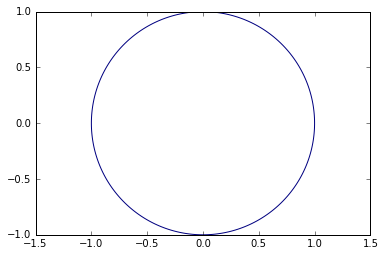

In [11]:
x = np.linspace(-1.0, 1.0, 100)
y = np.linspace(-1.0, 1.0, 100)
X, Y = np.meshgrid(x,y)

#Let's draw a circle of equation \sqrt{X^2 + Y^2} -1 = 0
C = np.sqrt(X**2 + Y**2) - 1
plt.contour(X,Y,C,[0])
plt.axis('equal')

One can now generalize the concept of distance in euclidean space, through Hilbert spaces in finite dimension using specific definition of dot product.

For instance, we can rewrite the norm $\|\|_2$ as $\|\|_{M_I}$ where $M_I$ is the identity matrix of size $n\times n$:
$$
M_I =
\begin{pmatrix}
    1 & 0 & \dots & 0\\
    0 & 1 & \ddots & \vdots\\
    \vdots & \ddots & \ddots & 0 \\
    0 & \dots & 0 & 1
\end{pmatrix}
$$

Using this notation, $\|x\|_{M_I}$ can be computed as $\sqrt{x^{\intercal} M_I x}$

One can scale the diagonal elements of $M_I$ so that overall norm will grow faster for some coordinates, in this case, the corresponding ball will be more constrained in that direction, let's take a simple 2D example:

$$
M_{aniso} =
\begin{pmatrix}
    1 & 0\\
    0 & 2
\end{pmatrix}
$$

Which give the following ball equation:
\begin{align*}
    \sqrt{x^{\intercal} M_{aniso} x} = 1\\
    \sqrt{x_1^2 + 2 x_2^2} -1 = 0
\end{align*}

(-1.0, 1.0, -1.0, 1.0)

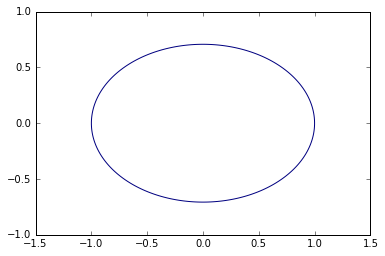

In [44]:
#Let's draw an axis aligned ellipsis of equation \sqrt{x^t Maniso x} -1 = 0

#Define Maniso, then flatten the meshgrid for matrix-vector product
Maniso = np.array([[1,0],[0,2]])
xvec = [np.reshape(X,X.size),np.reshape(Y,Y.size)]

#perform \sqrt{x^t Maniso x} -1 = 0
test=np.dot(Maniso,xvec)
E=np.sqrt(np.sum(test*xvec,0))-1

plt.contour(X,Y,np.reshape(E,X.shape),[0])
plt.axis('equal')

## Positive semi-definite matrix
Nice, the ellipsis is indeed more constrained along the $y$ direction. But what about the $M$ matrix that defines the self dot poduct used in the norm calculation ? Can we choose it randomly ?

Of course not, $M$ should be positive and semi definite, so that the square root can be applied to the result of $x^{\intercal}Mx \succeq 0$, and so that only the null vector $\vec{0}$ has a zeo norm. Unfortunately, positive definite is a rather abstract definition for a matrix, some even call it a convex cone which is even more abstract.

There are numerous example of PSD matrices:
- symmetric dyads $uu^{\intercal}$, PSD is easily provable because $x^{\intercal}uu^{\intercal}x = (u^{\intercal}x)^2 \geq 0$
- self product of matrix $M^{\intercal}M$, PSD i given by $x^{\intercal}M^{\intercal}Mx = (Mx)^2 \geq 0$
- Covariance matrix
- Gram matrix
- Laplacian matrix of a graph, see the notebook about Spectral gaph theory
- ...

Although not all definite positive matrices are symmetric, all matrices cited here are symmetric and PSD, and in general symmetric matrices are PSD, and can be diagonalized in an orthogonal basis.

This last assertion (that can be easily proven TODO) is very important, because it means geometrically that every symmetric matrix, can be expressed as an axis aligned dilation in a given rotated basis.

See for instance this simple 2D example that uses the previous dilation, and a rotation matrix $M_{rot}$ by angle $\theta = \frac{\pi}{8}$ :
$$
M_{rot} =
\begin{pmatrix}
    cos(\theta) & -sin(\theta)\\
    sin(\theta) & cos(\theta)
\end{pmatrix}
$$

(-1.0, 1.0, -1.0, 1.0)

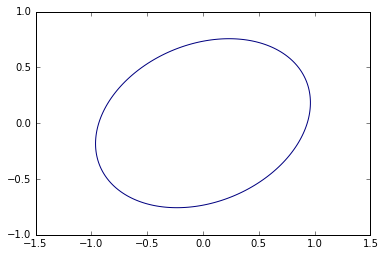

In [43]:
#define the rotation matrix:
theta = np.pi/8.
Mrot = np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])

#compute the rotation/dilation/inverse rotation matrix Manisorot = Mrot Maniso Mrot^t
Manisorot = np.dot(Maniso,Mrot.T)
Manisorot = np.dot(Mrot,Manisorot)

#perform \sqrt{x^t Manisorot x} -1 = 0
test=np.dot(Manisorot,xvec)
E=np.sqrt(np.sum(test*xvec,0))-1

plt.contour(X,Y,np.reshape(E,X.shape),[0])
plt.axis('equal')